In [1]:
# Import packages for calculation and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, AutoMinorLocator
# Pandas for convenient table export
import pandas as pd

## Brake station information

- Type: Type of brake system

    - TB: Tread Brake
    - DB: Disc Brake

- $p_C$: Brake cylinder pressure [Pa]
- $A_C$: Brake cylinder area [m$^2$]
- $i_C$: Cylinder transmission ratio [1]
- $\eta_C$: Cylinder efficiency [1]
- $F_{s,C}$: Return spring force [N]
- $i_{rig}$: Brake rigging transmission rate [1]
- $\eta_{rig,dyn}$: Brake rigging efficiency [1]
- $F_{s,rig}$: Brake rigging return spring force [N]
- $\mu_m$: Average brake pad or block friction coefficient [1]
- $r_S$: Effective friction radius [m]
- $D$: Wheel diameter [m]
- $t_a$: Delay time of cylinder pressure [s]
- $t_{ab}$: Rise time of cylinder pressure [s]
- $m_{st}$: Operating mass vehicle ready for service (per axle) [kg]
- $m_{rot}$: Rotating mass (per axle) [kg]

### Example data

Example data is a simplified version of EN14531-1, Appendix C.

![Vehicle image](xMU.png)

In [2]:
data = {'Type': ['1TB', '1TB', '1DB', '1DB', '1DB', '1DB','1TB', '1TB'],
        'pC': [3.8, 3.8, 3.0, 3.0, 3.0, 3.0, 3.8, 3.8],
        'AC': [346, 346, 324, 324, 324, 324, 346, 346], 
        'iC': [1, 1, 1, 1, 1, 1, 1, 1], 
        'etaC': [.95, .95, .98, .98, .98, .98, .95, .95], 
        'Fs,C': [-300, -300, -500, -500, -500, -500, -300, -300],
        'irig': [5, 5, 5, 5, 5, 5, 5, 5], 
        'etarig,dyn': [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95], 
        'Fs,rig': [-500, -500, 0, 0, 0, 0, -500, -500], 
        'mum': [0.28, 0.28, 0.35, 0.35, 0.35, 0.35, 0.28, 0.28], 
        'rS': [.5, .5, 0.27, 0.27, 0.27, 0.27, .5, .5], 
        'D': [1, 1, 0.89, 0.89, 0.89, 0.89, 1, 1], 
        'ta': [0.6, 0.6, 0.3, 0.3, 0.3, 0.3, 0.6, 0.6], 
        'tab': [3, 3, 2, 2, 2, 2, 3, 3],
        'mst': [15000, 15000, 14500, 14500, 14500, 14500, 15000, 15000],
        'mrot': [1500, 1500, 700, 700, 700, 700, 1500, 1500]
       }
df = pd.DataFrame(data = data, columns = ['Type','pC', 'AC', 'iC', 'etaC', 'Fs,C',
                        'irig', 'etarig,dyn', 'Fs,rig', 'mum', 
                        'rS', 'D', 'ta', 'tab', 'mst', 'mrot'])
df.to_excel('InputXMU.xlsx', index=False)

### Calculation of Forces

#### Brake cylinder force

Brake cylinder force is identical for disc and tread brake.

$$
F_C = p_C A_C i_C \eta_C + F_{c,C}
$$

#### Block or pad force

Block or pad forces may also be covered similarly when taking into account that $F_{s, rig} = 0$ for disc brakes and potentially $F_n$ relates to more than one block.

$$
F_n = F_b = F_C i_{rig} \eta_{rig, dyn} + F_{s, rig}
$$

#### Average force per brake unit

This worksheet omits transmissions (with $i_{tra}$ and $\eta_{tra}$). For tread brakes, select $r_S = \frac{1}{2} D$.

$$
\bar{F}_B,C = F_b \mu_m \frac{2 r_s}{D}
$$

In [3]:
# Brake cylinder force
df['FC'] = df['pC']*1e5*df['AC']*1e-4*df['iC']*df['etaC']+df['Fs,C']
# Block or pad force
df['Fb'] = df['FC']*df['irig']*df['etarig,dyn']+df['Fs,rig']
# Average force per brake unit
df['FB,i'] = df['Fb']*df['mum']*df['rS']/df['D']*2

#### Equivalent brake build-up time

\begin{equation}
t_{e,i} = t_a + \frac{t_{ab}}{2}
\end{equation}

In [4]:
# Equivalent brake build-up time
df['te,i'] = df['ta'] + 0.5*df['tab']

## Stopping distance calculation

Following losely EN 14531, App. D. The present calculcation takes into account rotating masses and a resistance force.

In [5]:
# Initial velocity
v0 = 45
# Terminal velocity
vfin = 0

### Dynamical mass (train level)

$$
m_{dyn} = \Sigma\left(m_{st} + m_{rot} \right)
$$

In [6]:
mdyn = df['mst'].sum() + df['mrot'].sum()

### Mean resistance

Ride resistance is calculcated as 

$$
\bar{F}_{Ra} = A + \frac{2}{3} B \frac{v_0^2 + v_0 v_{fin} + v_{fin}^2}{v_0 + v_{fin}} + \frac{1}{2} C \left(v_0^2 + v_{fin}^2\right)
$$

with coefficients $A$, $B$ and $C$ according to the vehicle.

In [7]:
# Vehicle data, resistance coefficients
A = 3000
B = 110
C = 7

FRa = A + 2/3*B*(v0**2 + v0*vfin + vfin**2)/(v0+vfin) + 1/2*C*(v0**2+vfin**2)

### Equivalent brake build up time

$$
t_e = \frac{\Sigma\left(t_{e,i} \bar{F}_{B,i} \right)}{\Sigma\bar{F}_{B,i} + \Sigma\bar{F}_{ext}}
$$



In [8]:
Fext = FRa
te = (df['te,i'] * df['FB,i']).sum()/(df['FB,i'].sum() + Fext)

### Equivalent retardation

$$
a_e = \frac{\Sigma\bar{F}_{B,i} + \Sigma\bar{F}_{ext}}{m_{dyn}}
$$

In [9]:
ae = (df['FB,i'].sum() + Fext)/mdyn

### Stopping distance

$$
s = v_0 t_e + \frac{v_0^2 - v_{fin}^2}{2 a_e}
$$

In [10]:
s = v0*te + (v0**2 - vfin**2)/(2*ae)

### Required adhesion

$$
\tau_{req} = \frac{\Sigma_{ax} \bar{F}_{B,i} - m_{rot, i} a_e}{m_{st} g}
$$

In [11]:
df['taureq'] = (df['FB,i'] - df['mrot']*ae)/(df['mst']*9.81)

### Energy and power calculcations

$$
W_{B,i} = F_{B,i} \left(s - v_0 t_e\right)
$$

$$
P_{max,i} = F_{B,i} v_0
$$

In [12]:
df['WB,i'] = df['FB,i']*(s-v0*te)
df['Pmax,i'] = df['FB,i']*v0

### Create summary table

In [13]:
result = [['m_dyn/kg', mdyn, 'Dynamical mass'],
        ['v_0/m/s^2', v0, 'Initial velocity'],
        ['F_Ra,m/N', FRa, 'Mean ride resistance'], 
        ['t_e/s', te, 'Equivalent build-up time'], 
        ['a_e/m/s^2', ae, 'Equivalent deceleration'], 
        ['s/m', s, 'Braking distande'], 
        ['tau_req', df['taureq'].max(), 'Required adhesion']]
dftrain = pd.DataFrame(data = result, columns = ['Key', 'Value', 'Semantic'])
dftrain.head(7)
dftrain.to_excel('OutputXMU.xlsx', index=False)

### Braked weight ratio

#### Replicate tests

Repeated brake distance measurements for 160 km/h, ...,100 km/h.



In [18]:
v0list = [100, 120, 140, 160]
bsdict = {}
for v0 in v0list:
    v0str = str(v0)
    v0 = v0/3.6 # Convert to m/s
    s = v0*te + (v0**2 - vfin**2)/(2*ae)
    bsdict[v0str] = s

#### Plot braking distances

Into plot according to EN 16834.

(40.0, 240.0)

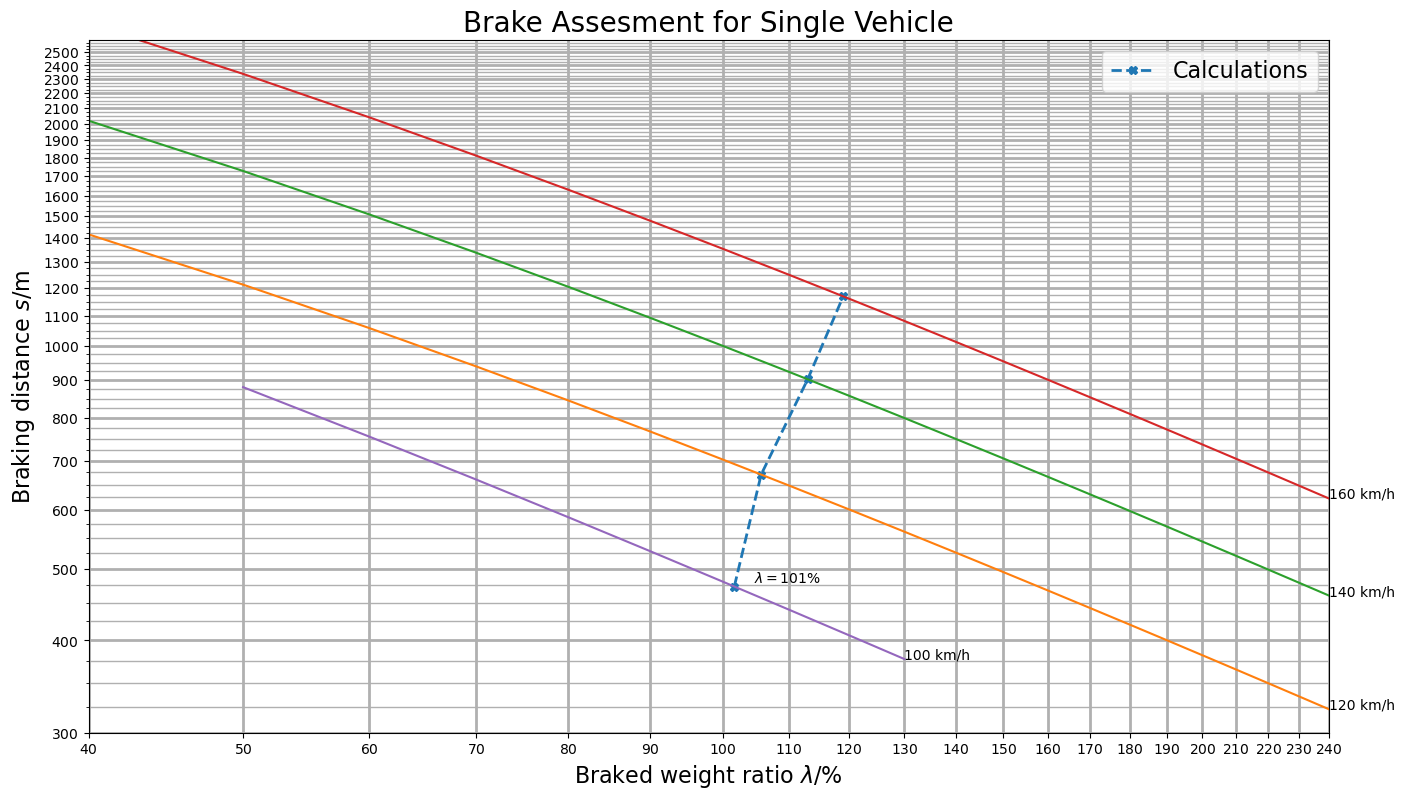

In [20]:
CDdict = {'100': [52840, 10],
'120': [83634, 19],
'140': [119179, 19],
'160': [161280, 19]}

# Single vehicles

curvedict = {}
for v in list(CDdict.keys())[1:]:
    l = np.arange(start = 40, stop = 250, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
for v in [100]:
    l = np.arange(start = 50, stop = 140, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
    
# Plotting
fig = plt.figure(figsize = (16, 9))
# Add measurements
bslambda = []
for v in list(CDdict.keys()):
    params = CDdict[str(v)]
    s = bsdict[str(v)]
    bslambda.append(params[0]/s-params[1])
plt.loglog(bslambda, list(bsdict.values()), 'X--', 
           linewidth = 2, label = "Calculations")
plt.annotate('$\lambda = $' + str(int(np.floor(np.min(bslambda)))) + '%', 
             (bslambda[0], list(bsdict.values())[0]),
            verticalalignment = 'top',
            xytext = (bslambda[0]+3, list(bsdict.values())[0]+25))
# Standard curves
for v in list(CDdict.keys())[1:]:
    c = curvedict[str(v)]
    l = np.arange(start = 40, stop = 250, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
for v in [100]:
    c = curvedict[str(v)]
    l = np.arange(start = 50, stop = 140, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
plt.legend(fontsize = 16)
# Limit axes
plt.ylim(300, 2600)
# Set ticks
plt.gca().set_yticks(ticks=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticklabels(labels=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticks(ticks=np.arange(300, 2600, 25), minor = True)
plt.gca().set_yticklabels(labels=[], minor = True)
plt.xticks(ticks=np.arange(30, 260, 10), labels=np.arange(300, 2600, 100))
# Set labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
# Activate grid
plt.grid(visible = True, which = 'major', linewidth = 2)
plt.grid(visible = True, which = 'minor', linewidth = 1)
# Axis labels
plt.xlabel('Braked weight ratio $\lambda/\%$', fontsize = 16)
plt.ylabel('Braking distance $s/\mathrm{m}$', fontsize = 16)
plt.title('Brake Assesment for Single Vehicle', fontsize = 20)
plt.xlim(40, 240)

## Separate plot of brake assesment graphic

As above, without plotted braking distances.

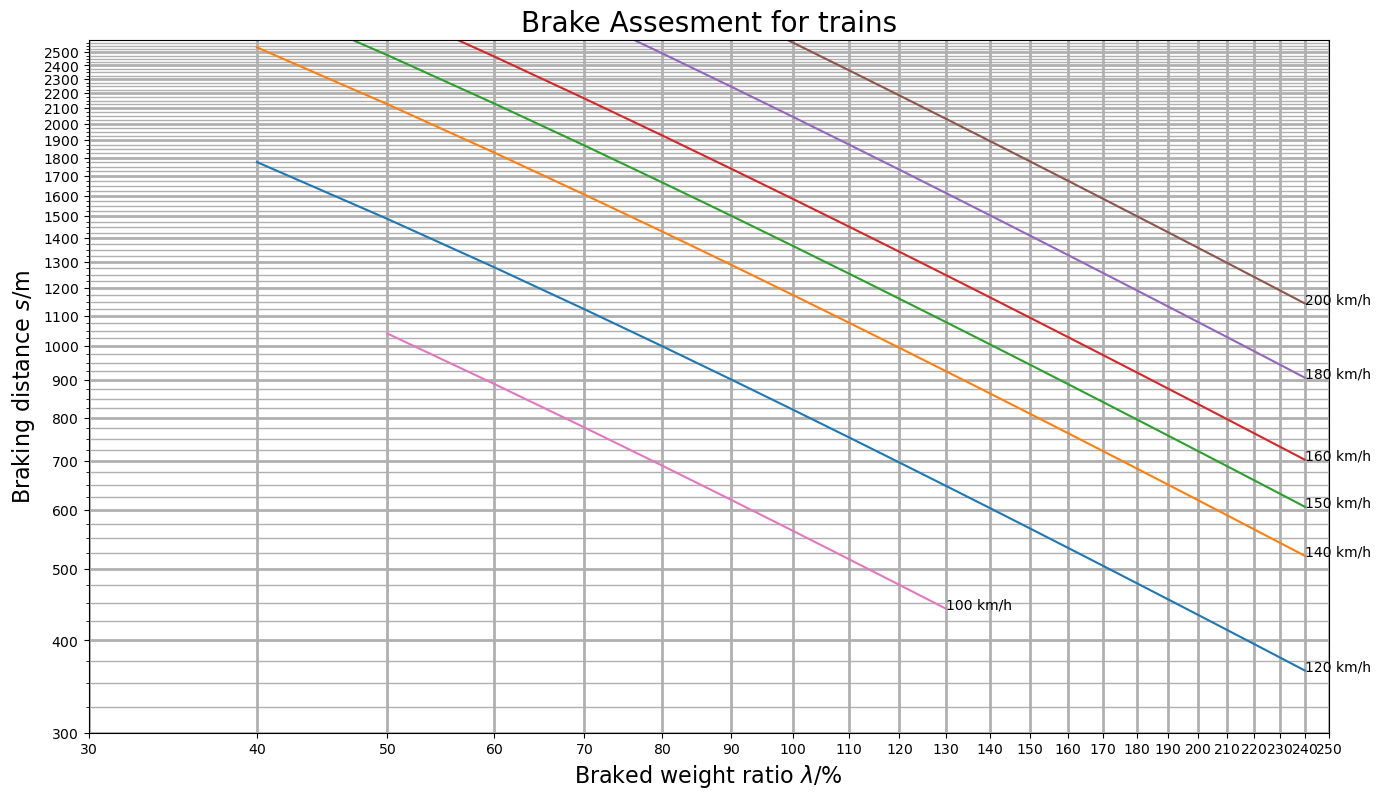

In [17]:
# Data for plot
CDdict = {'100': [61300, 8.9],
'120': [91633, 11.6],
'140': [130995, 11.6],
'150': [152640, 11.6],
'160': [176714, 11.6],
'180': [228219, 11.6],
'200': [287620, 11.6]}

curvedict = {}
for v in [120, 140, 150, 160, 180, 200]:
    l = np.arange(start = 40, stop = 250, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
for v in [100]:
    l = np.arange(start = 50, stop = 140, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
    
# Plotting
fig = plt.figure(figsize = (16, 9))
for v in [120, 140, 150, 160, 180, 200]:
    c = curvedict[str(v)]
    l = np.arange(start = 40, stop = 250, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
for v in [100]:
    c = curvedict[str(v)]
    l = np.arange(start = 50, stop = 140, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
# Limit axes
plt.ylim(300, 2600)
plt.xlim(40, 240)
# Set ticks
plt.gca().set_yticks(ticks=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticklabels(labels=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticks(ticks=np.arange(300, 2600, 25), minor = True)
plt.gca().set_yticklabels(labels=[], minor = True)
plt.xticks(ticks=np.arange(30, 260, 10), labels=np.arange(300, 2600, 100))
# Set labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
# Activate grid
plt.grid(visible = True, which = 'major', linewidth = 2)
plt.grid(visible = True, which = 'minor', linewidth = 1)
# Axis labels
plt.xlabel('Braked weight ratio $\lambda/\%$', fontsize = 16)
plt.ylabel('Braking distance $s/\mathrm{m}$', fontsize = 16)
plt.title('Brake Assesment for trains', fontsize = 20)
plt.savefig('BrakeAssesment.pdf')

---
## German version

### Bremsgewicht nach UIC 544-1

#### Bremswege plotten

In Graphen nach UIC 544-1.

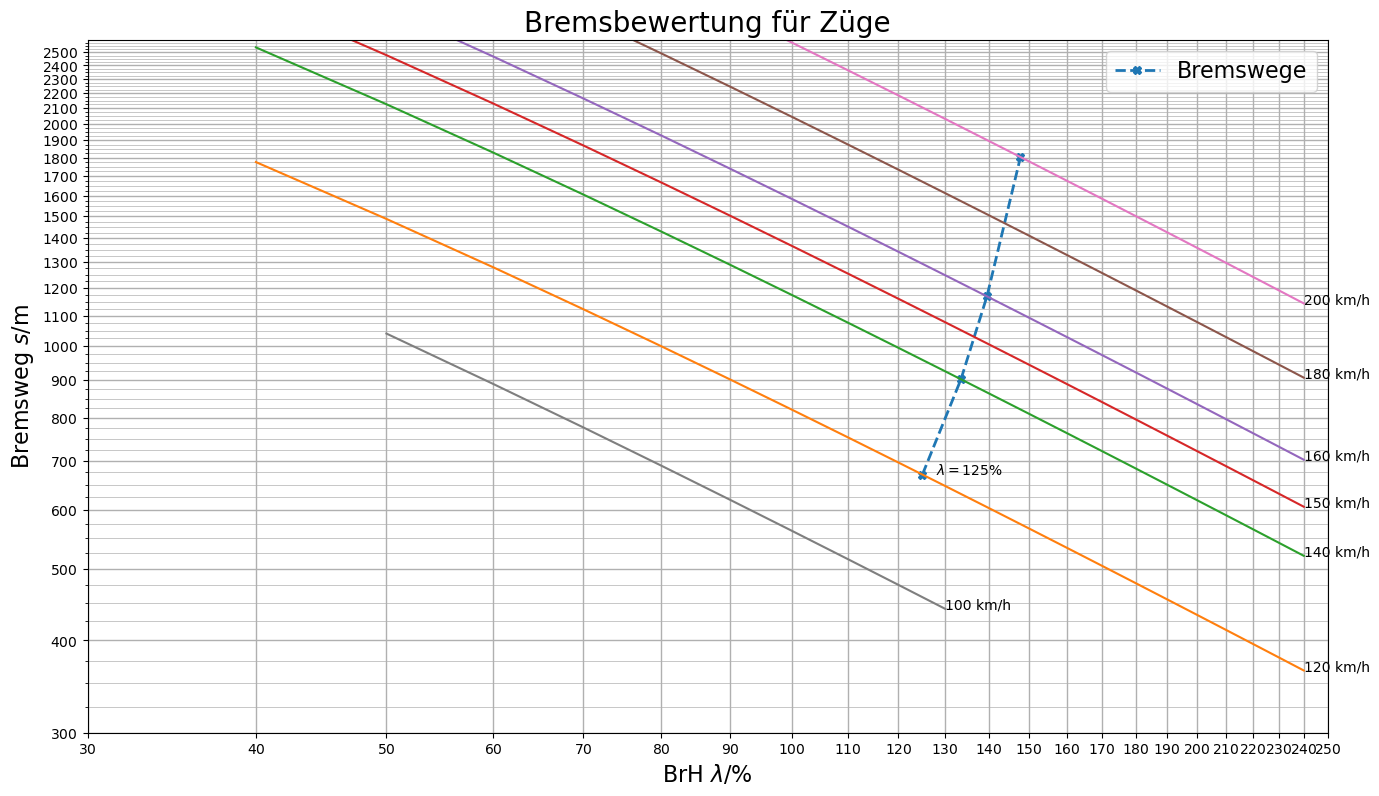

In [18]:
# Struct to contain values for conversion s <-> lambda
CDdict = {'100': [61300, 8.9],
'120': [91633, 11.6],
'140': [130995, 11.6],
'150': [152640, 11.6],
'160': [176714, 11.6],
'180': [228219, 11.6],
'200': [287620, 11.6]}

curvedict = {}
for v in [120, 140, 150, 160, 180, 200]:
    l = np.arange(start = 40, stop = 250, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
for v in [100]:
    l = np.arange(start = 50, stop = 140, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
    
# Plotting
fig = plt.figure(figsize = (16, 9))
# Add measurements
bslambda = []
for v in [120, 140, 160, 200]:
    params = CDdict[str(v)]
    s = bsdict[str(v)]
    bslambda.append(params[0]/s-params[1])
plt.loglog(bslambda, list(bsdict.values()), 'X--', 
           linewidth = 2, label = "Bremswege")
plt.annotate('$\lambda = $' + str(int(np.floor(np.min(bslambda)))) + '%', 
             (bslambda[0], list(bsdict.values())[0]),
            verticalalignment = 'top',
            xytext = (bslambda[0]+3, list(bsdict.values())[0]+26))
# Standard curves
for v in [120, 140, 150, 160, 180, 200]:
    c = curvedict[str(v)]
    l = np.arange(start = 40, stop = 250, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
for v in [100]:
    c = curvedict[str(v)]
    l = np.arange(start = 50, stop = 140, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
plt.legend(fontsize = 16)
# Limit axes
plt.ylim(300, 2600)
plt.xlim(40, 240)
# Set ticks
plt.gca().set_yticks(ticks=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticklabels(labels=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticks(ticks=np.arange(300, 2600, 25), minor = True)
plt.gca().set_yticklabels(labels=[], minor = True)
plt.xticks(ticks=np.arange(30, 260, 10), labels=np.arange(300, 2600, 100))
# Set labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
# Activate grid
plt.grid(visible = True, which = 'major', linewidth = 1)
plt.grid(visible = True, which = 'minor', linewidth = .5)
# Axis labels
plt.xlabel('BrH $\lambda/\%$', fontsize = 16)
plt.ylabel('Bremsweg $s/\mathrm{m}$', fontsize = 16)
plt.title('Bremsbewertung für Züge', fontsize = 20)
plt.savefig('BrakeAssesmentwMeasurementsDE.pdf')